In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [34]:
h=pd.read_pickle('data/h.pkl').sort_values('ez',ascending=False)
h[h.ch=='chr7'].head(1)

,ch,b,e,d,r,rd,ez1,ez2,ez
34815,chr7,137309054,137315812,6758,"{137310208, 137314313, 137310232, 137314328, 1...",475,4.04848,4.97202,9.0205


In [35]:
hg=h.groupby('ch')['r'].apply(list)
hg=hg.apply(lambda x:set.union(*x))

In [27]:
rrbs='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE120nnn/GSE120137/matrix/GSE120137-GPL21103_series_matrix.txt.gz'
age=pd.read_table(rrbs,skiprows=31).T
age=age.drop('!Sample_title')
age['age']=age[10].str[5:].str[:-2].astype(float)
age['id']=age.index.str[-3:]

In [ ]:
ps={}
fs=glob.glob('data/meth/GSE120137/l/*.txt')
fs.sort()
print(len(fs))
n=7
dfs=[]
for sn in fs:
    name=sn.split('SH')[1][:3]
    print(name,end=',')
    df=pd.read_table(sn,engine='c',sep=' ',header=None,nrows=10**n)
    df=df[df[0].isin(hg.index)]
    df['hmr']=df.apply(lambda x:x[2]-1 in hg[x[0]],axis=1)
    df=df[df['hmr']][[0,2,5]]
    df.index=df[0].str[3:5]+'_'+(df[2]-1).astype(str)
    #h[name]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    dfs.append(df[5].rename(name))

In [52]:
hzs=[]
for i,rr in h.head(100).iterrows():
    for r in list(rr['r']):
        hzs.append(rr['ch'][3:5]+'_'+str(r))
len(hzs)

24429

In [54]:
for c in ['m','a','k','l','u','b']:
    fs=glob.glob('data/meth/GSE120137/'+c+'/csv/*.csv')
    dfs=[]
    for f in fs:
        print ('',end=',')
        df=pd.read_csv(f,index_col=0)
        df=df[df.index.isin(hzs)]
        dfs.append(df)
    df=dfs[0].merge(dfs[1],left_index=True,right_index=True,how='outer')
    for i in range(2,len(dfs)):
        print(i,end=',')
        df=df.merge(dfs[i],left_index=True,right_index=True,how='outer')
    df.shape
    p=df.mean()
    p=p.rename('DNAm')
    ps[c]=age[['id','age']].drop_duplicates().merge(p,left_on='id',right_index=True)    

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

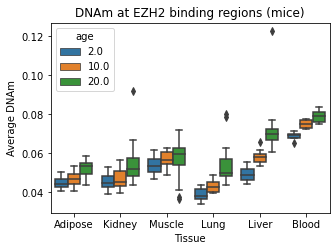

In [59]:
ps['m']['Tissue']='Muscle'
ps['a']['Tissue']='Adipose'
ps['k']['Tissue']='Kidney'
ps['l']['Tissue']='Liver'
ps['u']['Tissue']='Lung'
ps['b']['Tissue']='Blood'
ps['bb']=ps['b'][ps['b'].age.isin([2,10,20])]
del ps['b']
fig, ax = plt.subplots(figsize=(5,3.5))
ax=sns.boxplot(data=pd.concat(ps),x='Tissue',y='DNAm',hue='age'
            ,order=['Adipose','Kidney','Muscle','Lung','Liver','Blood']);
ax.set(title='DNAm at EZH2 binding regions (mice)',ylabel='Average DNAm');